# 1 异常检测概念

异常检测（Outlier Detection），顾名思义，是识别与正常数据不同的数据，与预期行为差异大的数据。

识别如信用卡欺诈，工业生产异常，网络流里的异常（网络侵入）等问题，针对的是少数的事件。

## 1.1 异常检测的类别

点异常（point anomalies）指的是少数个体实例是异常的，大多数个体实例是正常的，例如正常人与病人的健康指标；

条件异常（conditional anomalies），又称上下文异常，指的是在特定情境下个体实例是异常的，在其他情境下都是正常的，例如在特定时间下的温度突然上升或下降，在特定场景中的快速信用卡交易；

群体异常（group anomalies）指的是在群体集合中的个体实例出现异常的情况，而该个体实例自身可能不是异常，在入侵或欺诈检测等应用中，离群点对应于多个数据点的序列，而不是单个数据点。例如社交网络中虚假账号形成的集合作为群体异常子集，但子集中的个体节点可能与真实账号一样正常。

## 1.2 异常检测任务分类

有监督：训练集的正例和反例均有标签

无监督：训练集无标签

半监督：在训练集中只有正例，异常实例不参与训练

## 1.3 异常检测场景

故障检测：主要是监控系统，在故障发生时可以识别，并且准确指出故障的种类以及出现位置。主要应用领域包括银行欺诈、移动蜂窝网络故障、保险欺诈、医疗欺诈。

医疗日常检测：在许多医疗应用中，数据是从各种设备收集的，如磁共振成像（MRI）扫描、正电子发射断层扫描（PET）扫描或心电图（ECG）时间序列。这些数据中的异常模式通常反映疾病状况。

网络入侵检测：在许多计算机系统中，都会收集有关操作系统调用、网络流量或其他用户操作的不同类型的数据。由于恶意活动，此数据可能显示异常行为。对此类活动的识别称为入侵检测。

欺诈检测：信用卡欺诈越来越普遍，因为信用卡号码等敏感信息更容易被泄露。在许多情况下，未经授权使用信用卡可能表现出不同的模式，例如从特定地点疯狂购买或进行非常大的交易。这种模式可用于检测信用卡交易数据中的异常值。

工业异常检测

时间序列异常检测

视频异常检测

日志异常检测

## 1.4 异常检测的难点

1.数据量少。异常检测任务通常情况下负样本（异常样本）是比较少的，有时候依赖于人工标签，属于样本不平衡问题。

2.噪音。异常和噪音有时候很难分清，如下图，图a的A点位于数据的稀疏区域，与其他数据非常不同，因此可以断定为异常，但是像图b的A点，周围有也有很多点分布，我们很难把A点识别出来。

# 2 实例

以笔者所研究的电厂氮氧化物数据为例，下面导入需要的库

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
matplotlib.rcParams['font.sans-serif'] = ['SimHei']

导入数据,数据序列间隔10s采样

In [17]:
data = pd.read_csv('D:\\脱硝\\guiyi_nmidata.csv', sep=',')
data

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.182475,0.192797,0.113258,0.253146,0.241669,0.226433,0.793893,0.624557,0.349827,0.236512,0.416597,0.452947,252.55899
1,0.189999,0.197179,0.122330,0.248932,0.238871,0.194965,0.814249,0.628493,0.349827,0.236512,0.417393,0.449584,254.50899
2,0.189999,0.197179,0.122330,0.248932,0.238871,0.194965,0.814249,0.628493,0.348305,0.231341,0.417393,0.449584,254.50899
3,0.184139,0.192439,0.113363,0.247989,0.238871,0.197565,0.722646,0.632428,0.348305,0.231341,0.336509,0.447631,262.01299
4,0.184139,0.192439,0.113363,0.247989,0.239555,0.197565,0.722646,0.632428,0.346754,0.233562,0.336509,0.447631,262.01299
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.501652,0.420755,0.625794,0.654965,0.482529,0.399234,0.600509,0.474223,0.375528,0.601305,0.568559,0.373045,281.09600
19996,0.501497,0.426743,0.603669,0.654022,0.482529,0.391162,0.597964,0.478552,0.375528,0.601305,0.574404,0.374676,276.23400
19997,0.501497,0.426743,0.603669,0.654022,0.482779,0.391162,0.597964,0.478552,0.375528,0.601305,0.574404,0.374676,276.23400
19998,0.496389,0.418908,0.607291,0.651666,0.482779,0.415516,0.581425,0.482487,0.377452,0.604529,0.564984,0.374554,271.96000


虽然所研究内容和时间相关性不太强，但是这仍然是一段时间序列，对其中的异常数据进行检测后不能直接删除，后续还需要进行一定的数据清洗
这里使用氮氧化物浓度的数据

In [18]:
air_total=data.iloc[:,12]
air_total.shape

(20000,)

In [25]:
x=np.arange(0,10000)

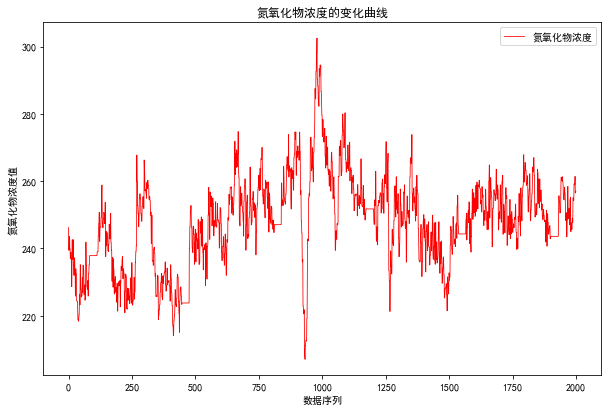

In [27]:
plt.figure(figsize=(10,6.5))
plt.plot(x[:2000],air_total[3000:5000],'r',linewidth=0.8,label='氮氧化物浓度')
plt.xlabel('数据序列')
plt.ylabel('氮氧化物浓度值')
plt.title('氮氧化物浓度的变化曲线')
plt.legend()
plt.show()

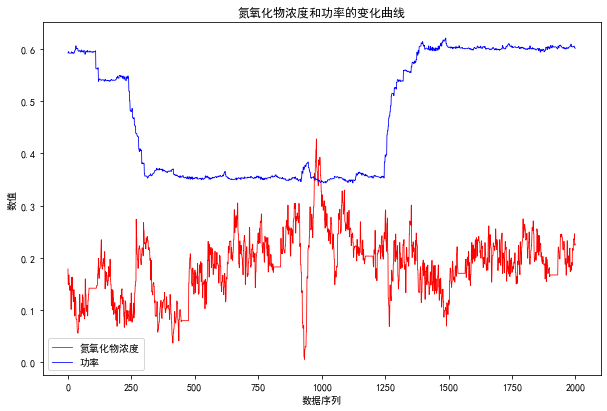

In [31]:
ydata = data.iloc[:, 12]
ydata = (ydata - np.min(ydata)) / (np.max(ydata) - np.min(ydata))
gonglv=data.iloc[3000:5000,4]
plt.figure(figsize=(10,6.5))
plt.plot(x[:2000],ydata[3000:5000],'r',linewidth=0.8,label='氮氧化物浓度')
plt.plot(x[:2000],gonglv,'b',linewidth=0.8,label='功率')
plt.xlabel('数据序列')
plt.ylabel('数值')
plt.title('氮氧化物浓度和功率的变化曲线')
plt.legend()
plt.show()

       由于电厂人员误操作或者数据采集器故障，采集得到的数据会存在许多异常值。上图可以看出，在第900~1000左右的数据时突然下降和上升，可以认为是异常数据。电厂数据中存在大量如上图所示的异常数据，所以如何通过算法而不是直接看图实现对异常数据的检测，则是接下来学习过程中将要解决的问题。